In [1]:
from datetime import datetime

import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as u
import numpy as np
import pytz
from IPython.display import HTML

import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib.dates import HourLocator, MinuteLocator, DateFormatter
import matplotlib.animation as animation
import matplotlib as mpl

In [2]:
# Set timezone here:
mpl.rcParams["timezone"] = "US/Eastern"

# Enter address here:
address = "4 Ivy Lane, Princeton, NJ"

Set up an array of times to get the sun and moon position during:

In [3]:
tz = pytz.timezone(mpl.rcParams["timezone"])
times = (
    Time(datetime(2017, 8, 21, 8, 0, 0).astimezone(pytz.UTC))
    + np.linspace(0, 12, 1024) * u.hour
)
dt = times.to_datetime(tz)

Get objects representing your location on Earth, the moon's position, the sun's position

In [4]:
loc = coord.EarthLocation.of_address(address)
moon = coord.get_moon(times)
sun = coord.get_sun(times)

Transform to Altitude-Azimuth coordinates at the specified location:

In [5]:
alt_az = coord.AltAz(obstime=times, location=loc)
moon_aa = moon.transform_to(alt_az)
sun_aa = sun.transform_to(alt_az)

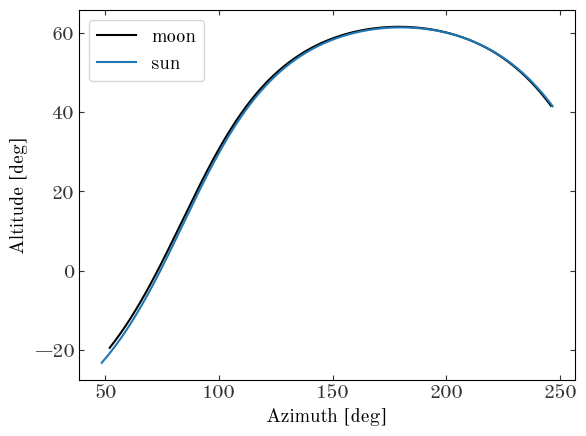

In [6]:
plt.plot(moon_aa.az, moon_aa.alt, marker="None", linestyle="-", label="moon")
plt.plot(sun_aa.az, sun_aa.alt, marker="None", linestyle="-", label="sun")
plt.xlabel("Azimuth [deg]")
plt.ylabel("Altitude [deg]")
plt.legend()

Compute the separation between the moon and the sun. Plot the separation around the time of minimum:

In [7]:
sun_moon_sep = moon_aa.separation(sun_aa)

Text(0, 0.5, 'Sun–Moon separation [arcmin]')

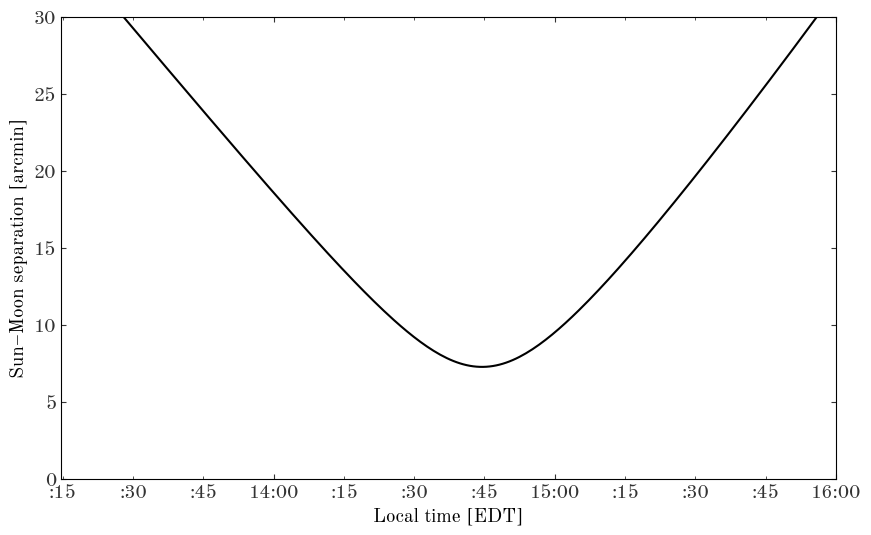

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(dt, sun_moon_sep.to(u.arcmin), marker="None")

ax.xaxis_date(tz=tz)
ax.set_xlim(
    dt[max(sun_moon_sep.argmin() - 128, 0)],
    dt[min(sun_moon_sep.argmin() + 128, len(dt) - 1)],
)

ax.xaxis.set_major_locator(HourLocator())
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax.xaxis.set_minor_locator(MinuteLocator(byminute=np.arange(15, 60, 15)))
ax.xaxis.set_minor_formatter(DateFormatter(":%M"))

ax.set_ylim(0, 30)

ax.set_xlabel(f"Local time [{dt[0]:%Z}]")
ax.set_ylabel("Sun–Moon separation [arcmin]")

Now we'll make an animation of the eclipse, centered on the Sun's position first:

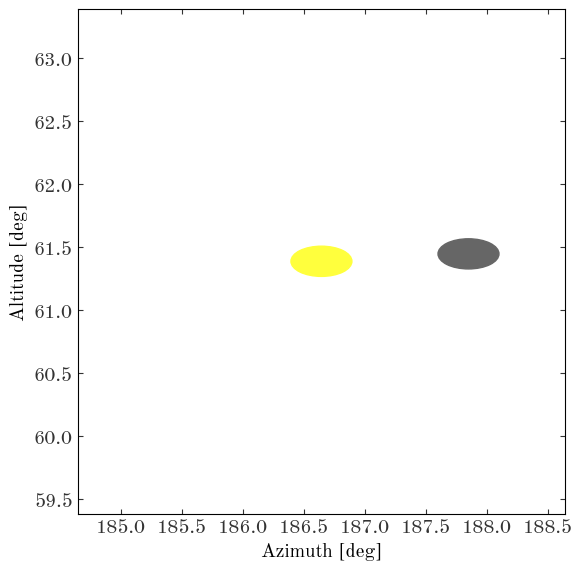

In [9]:
i0 = max(sun_moon_sep.argmin() - 128, 0)
i1 = min(sun_moon_sep.argmin() + 128, len(dt) - 1)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

x = np.arange(0, 2 * np.pi, 0.01)

moon_pa = mpl.patches.Ellipse((0, 0), width=0.5, height=0.5, color="#666666", zorder=10)
sun_pa = mpl.patches.Ellipse((0, 0), width=0.5, height=0.5, color="#ffff3d", zorder=1)
ax.add_patch(moon_pa)
ax.add_patch(sun_pa)

ax.set_xlabel("Azimuth [deg]")
ax.set_ylabel("Altitude [deg]")

fig.tight_layout()


def animate(i):
    moon_pa.center = [moon_aa.az[i].degree, moon_aa.alt[i].degree]
    sun_pa.center = [sun_aa.az[i].degree, sun_aa.alt[i].degree]

    moon_pa.height = 0.5 * np.cos(moon_aa.alt[i])
    sun_pa.height = 0.5 * np.cos(sun_aa.alt[i])

    az_lim = (sun_aa.az[i].to(u.degree).value - 2, sun_aa.az[i].to(u.degree).value + 2)
    alt_lim = (
        sun_aa.alt[i].to(u.degree).value - 2,
        sun_aa.alt[i].to(u.degree).value + 2,
    )

    ax.set_xlim(az_lim)
    ax.set_ylim(alt_lim)

    return moon_pa, sun_pa


def init():
    return animate(i0)


ani = animation.FuncAnimation(
    fig, animate, np.arange(i0, i1), init_func=init, interval=25, blit=True
)

In [10]:
HTML(ani.to_html5_video())

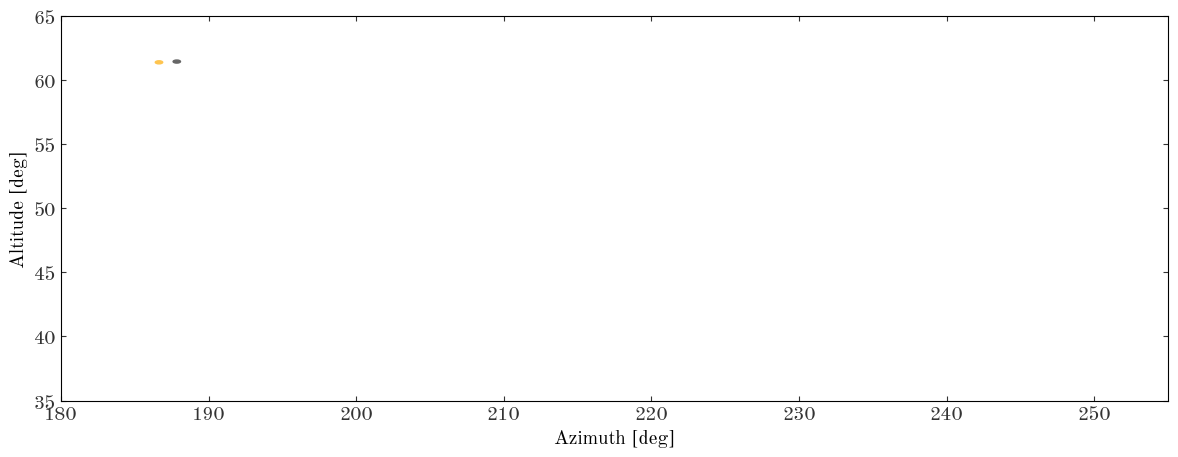

In [11]:
fig2, ax = plt.subplots(1, 1, figsize=(12, 4.8))

x = np.arange(0, 2 * np.pi, 0.01)

moon_pa = mpl.patches.Ellipse((0, 0), width=0.5, height=0.5, color="#666666", zorder=10)
sun_pa = mpl.patches.Ellipse((0, 0), width=0.5, height=0.5, color="#fec44f", zorder=1)
ax.add_patch(moon_pa)
ax.add_patch(sun_pa)

ax.set_xlabel("Azimuth [deg]")
ax.set_ylabel("Altitude [deg]")

ax.set_xlim(180, 255)
ax.set_ylim(35, 65)

fig2.tight_layout()


def animate2(i):
    moon_pa.center = [moon_aa.az[i].degree, moon_aa.alt[i].degree]
    sun_pa.center = [sun_aa.az[i].degree, sun_aa.alt[i].degree]

    moon_pa.height = 0.5 * np.cos(moon_aa.alt[i])
    sun_pa.height = 0.5 * np.cos(sun_aa.alt[i])

    return moon_pa, sun_pa


def init2():
    return animate2(i0)


ani2 = animation.FuncAnimation(
    fig2, animate2, np.arange(i0, i1), init_func=init2, interval=25, blit=True
)

ani2

In [12]:
HTML(ani2.to_html5_video())